# Wstęp
 
Celem niniejszego sprawozdania jest analiza oraz przygotowanie modelu uczenia maszynowego do prognozowania cen mieszkań w Polsce na podstawie publicznego zbioru danych “Apartment Prices in Poland” udostępnionego na platformie Kaggle. Zbiór zawiera oferty dotyczące rynku mieszkaniowego (ogłoszenia) w największych miastach w Polsce 

Dane obejmują okres od sierpnia 2023 do stycznia 2024 (miesięczne wycinki/aktualizacje), co pozwala obserwować zmienność rynku w krótkim horyzoncie czasowym i uwzględniać potencjalny efekt sezonowości.  ￼
Każda obserwacja opisuje pojedynczą ofertę mieszkaniową i zawiera zestaw cech opisujących nieruchomość, takich jak m.in.: miasto, metraż, liczba pokoi, a także wybrane informacje o budynku i otoczeniu.

W ramach sprawozdania przedstawione zostaną: wstępna eksploracja danych i analiza rozkładów, przygotowanie danych do modelowania, inżynieria cech oraz budowa i ocena modeli predykcyjnych z użyciem standardowych miar jakości dla regresji.

Na końcu pracy sformułowane zostaną wnioski dotyczące jakości predykcji oraz interpretacji czynników, które najsilniej wpływają na poziom cen mieszkań w analizowanym okresie i miastach.

In [4]:
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option("display.max_columns", None)         # pokazuj wszystkie kolumny
# pd.set_option("display.width", 2000)               # większa "szerokość" wydruku
# pd.set_option("display.max_colwidth", 80)          # limit szerokości komórki (ustaw np. None, jeśli chcesz bez limitu)
pd.set_option("display.expand_frame_repr", False)  # nie łam DataFrame na kilka "bloków" w pionie

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

DATA_DIR = Path("data")  # folder z CSV
CSV_GLOB = "*.csv"

SNAPSHOT_RE = re.compile(r"(?P<year>20\d{2})[_-](?P<month>\d{2})")

paths = sorted(DATA_DIR.glob(CSV_GLOB))
if not paths:
    raise FileNotFoundError(f"Brak plików CSV w: {DATA_DIR.resolve()}")

[p.name for p in paths[:10]], len(paths)

dfs = []

for p in paths:
    df = pd.read_csv(p)

    # snapshot_date z nazwy pliku: YYYY_MM lub YYYY-MM -> YYYY-MM-01
    m = SNAPSHOT_RE.search(p.name)
    snapshot_date = pd.NaT
    if m:
        snapshot_date = pd.Timestamp(year=int(m.group("year")), month=int(m.group("month")), day=1)

    df["source_file"] = p.name
    df["snapshot_date"] = snapshot_date
    df["snapshot_year"] = pd.to_datetime(df["snapshot_date"]).dt.year
    df["snapshot_month"] = pd.to_datetime(df["snapshot_date"]).dt.month

    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all['price_per_m2'] = df_all['price'] / df_all['squareMeters']
df_all.shape

display(df_all[['city', 'price', 'squareMeters', 'price_per_m2']].head())

# Rozpoznanie po nazwie pliku (source_file)
# rent -> ma "rent" w nazwie
mask_rent = df_all["source_file"].str.lower().str.contains("rent", na=False)

# sell/ceny -> wszystko co NIE jest rent
mask_sell = ~mask_rent

df_rent = df_all[mask_rent].copy()
df_sell = df_all[mask_sell].copy()

df_rent.describe


city   price  squareMeters  price_per_m2
0  szczecin  415000         63.00   6587.301587
1  szczecin  395995         36.00  10999.861111
2  szczecin  565000         73.02   7737.606135
3  szczecin  640000         87.60   7305.936073
4  szczecin  759000         66.00  11500.000000

<bound method NDFrame.describe of                                       id       city               type  squareMeters  rooms  floor  floorCount  buildYear   latitude  longitude  centreDistance  poiCount  schoolDistance  clinicDistance  postOfficeDistance  kindergartenDistance  restaurantDistance  collegeDistance  pharmacyDistance    ownership buildingMaterial condition hasParkingSpace hasBalcony hasElevator hasSecurity hasStorageRoom  price                     source_file snapshot_date  snapshot_year  snapshot_month  price_per_m2
195568  2a1a6db97ff122d6bc148abb6f0e498a   szczecin       blockOfFlats          52.0    2.0    3.0         3.0     2008.0  53.460535  14.545416            4.26       2.0           0.753           1.049               0.595                 0.674               0.229            2.200             0.307  condominium            brick       NaN             yes        yes          no          no             no   3500  apartments_rent_pl_2023_11.csv    2023-11-01      

# 4. Profil zmiennych kategorycznych

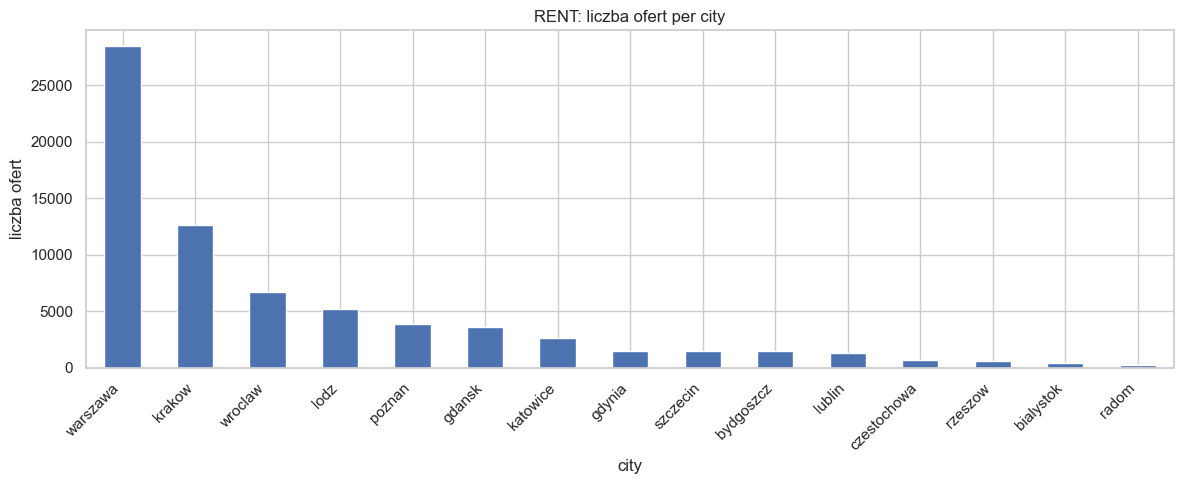

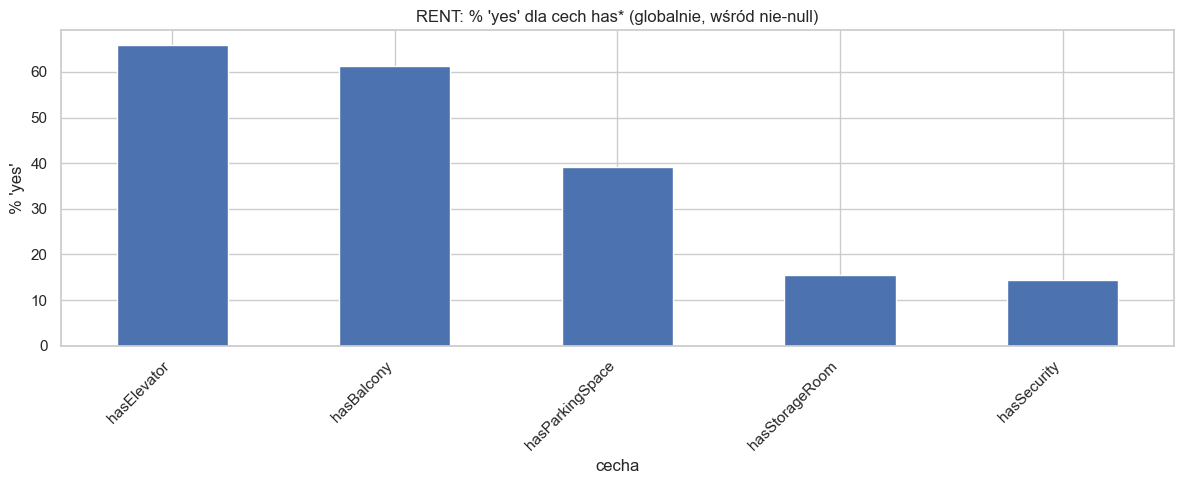

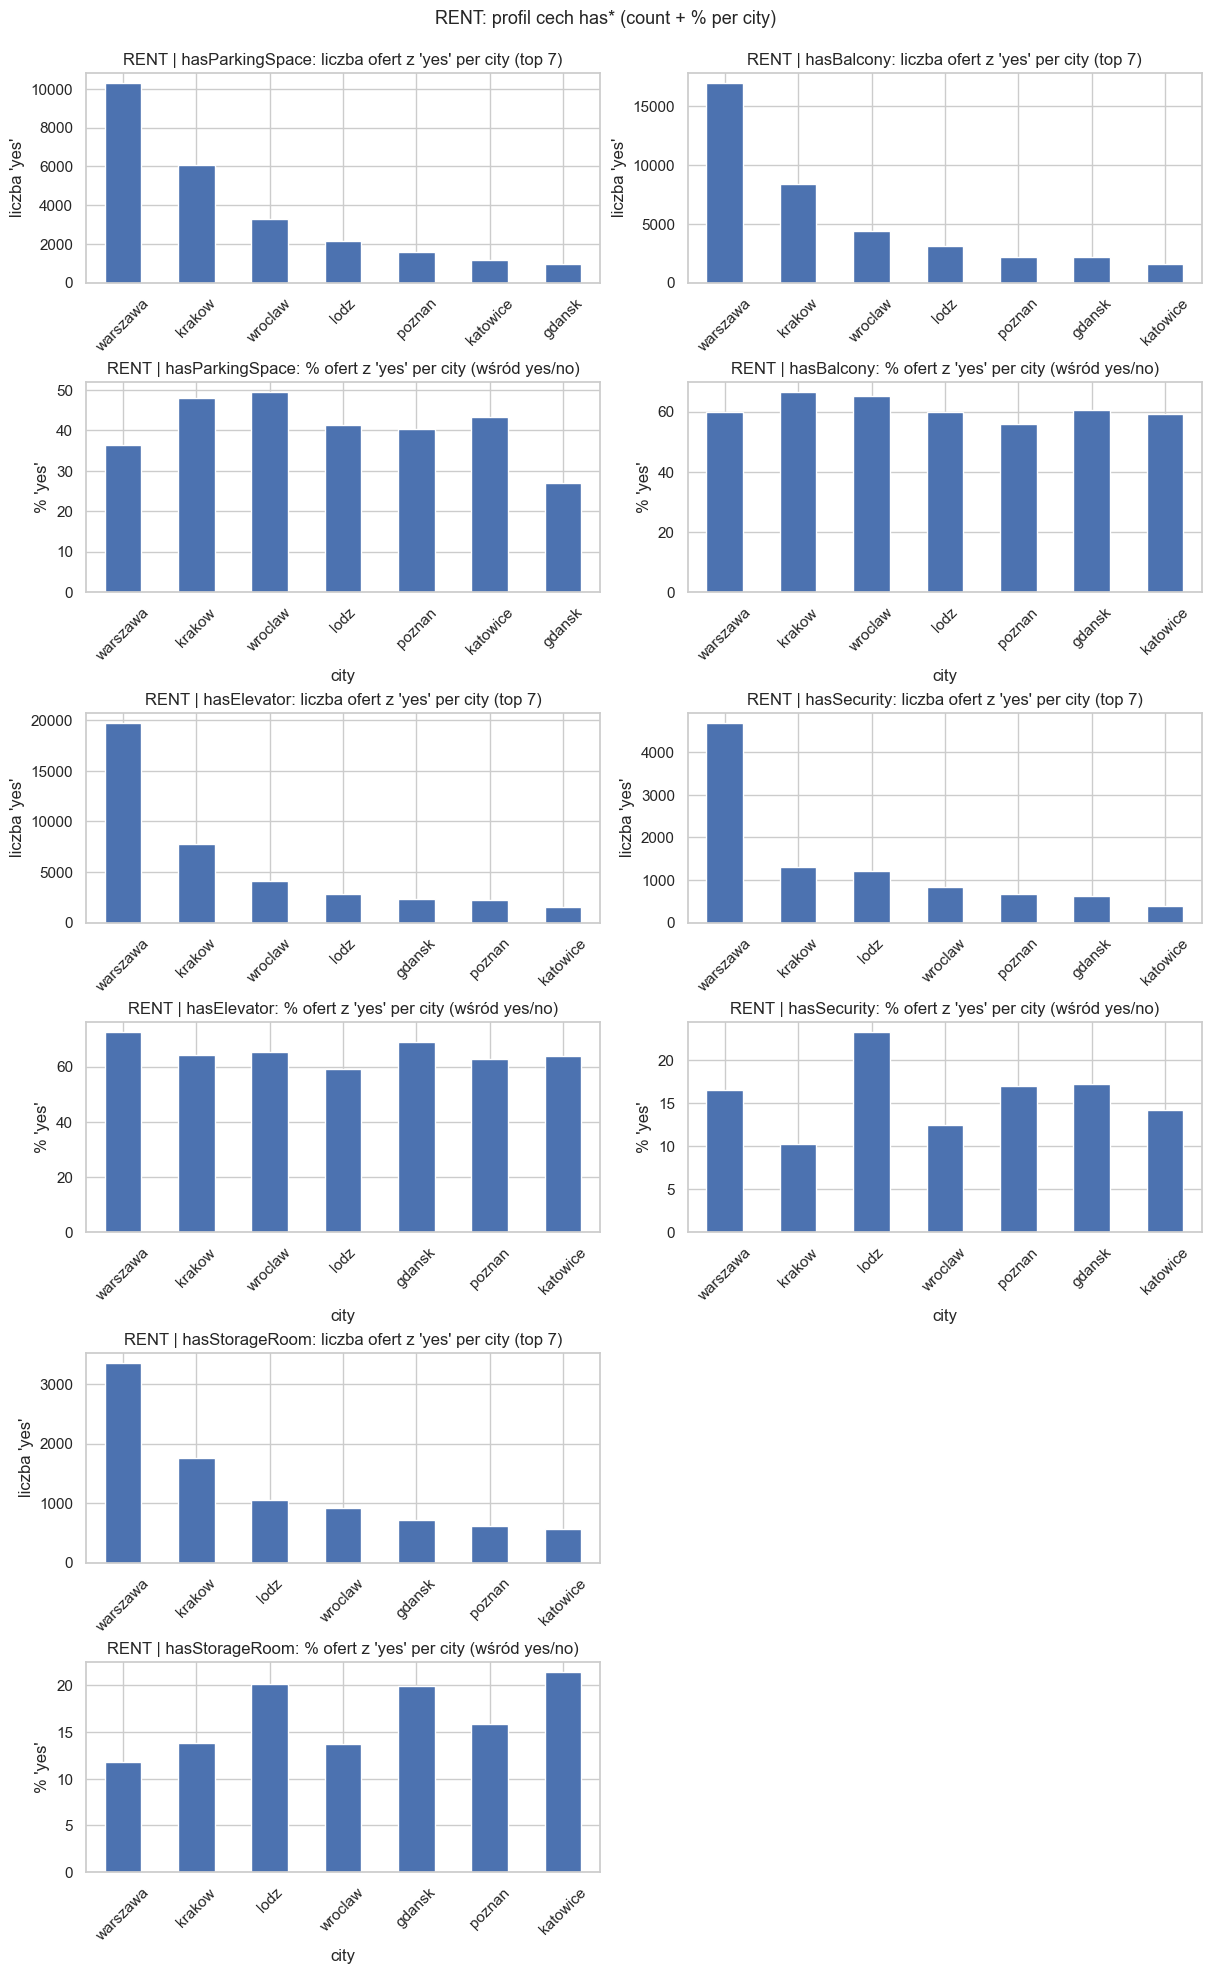

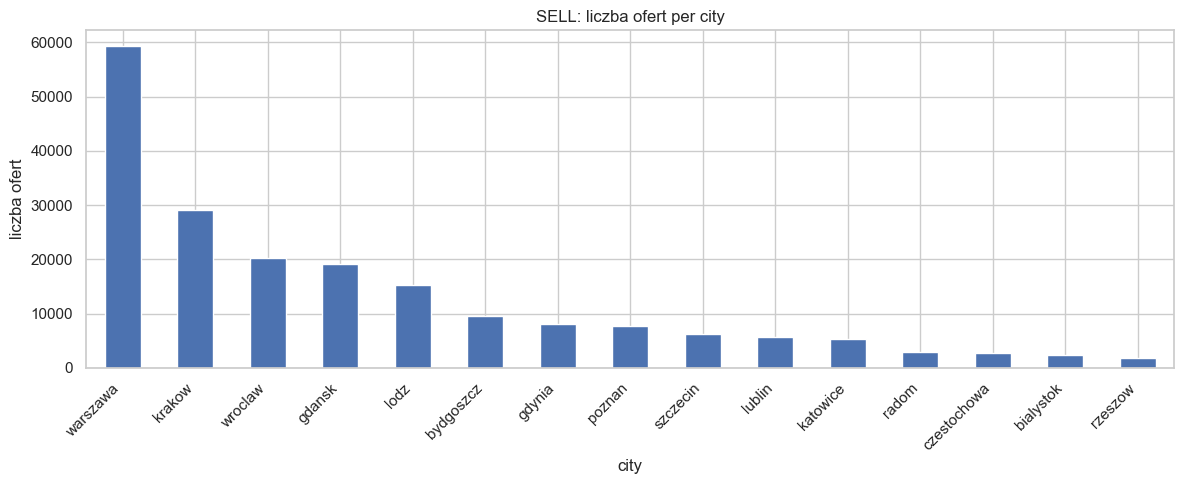

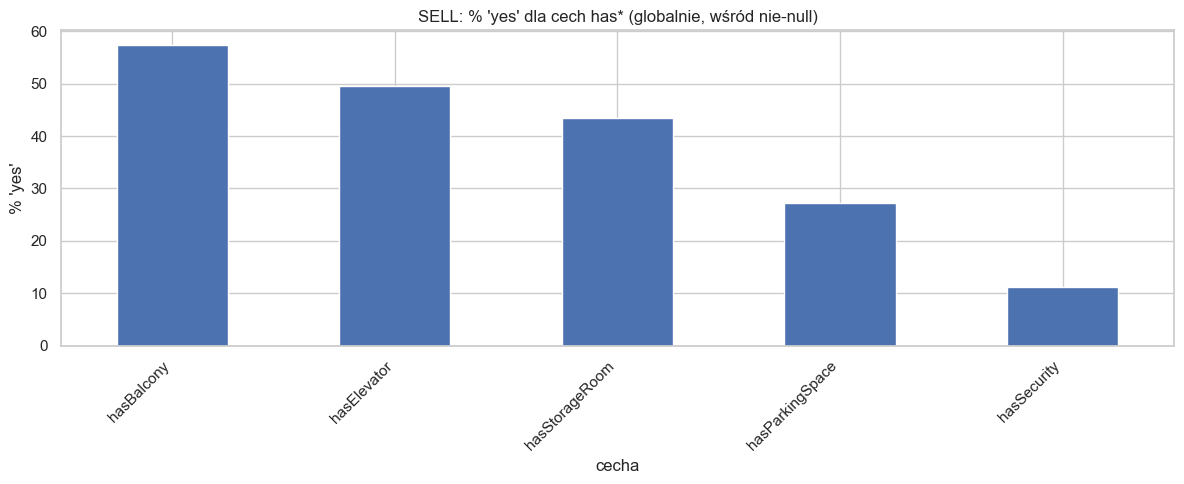

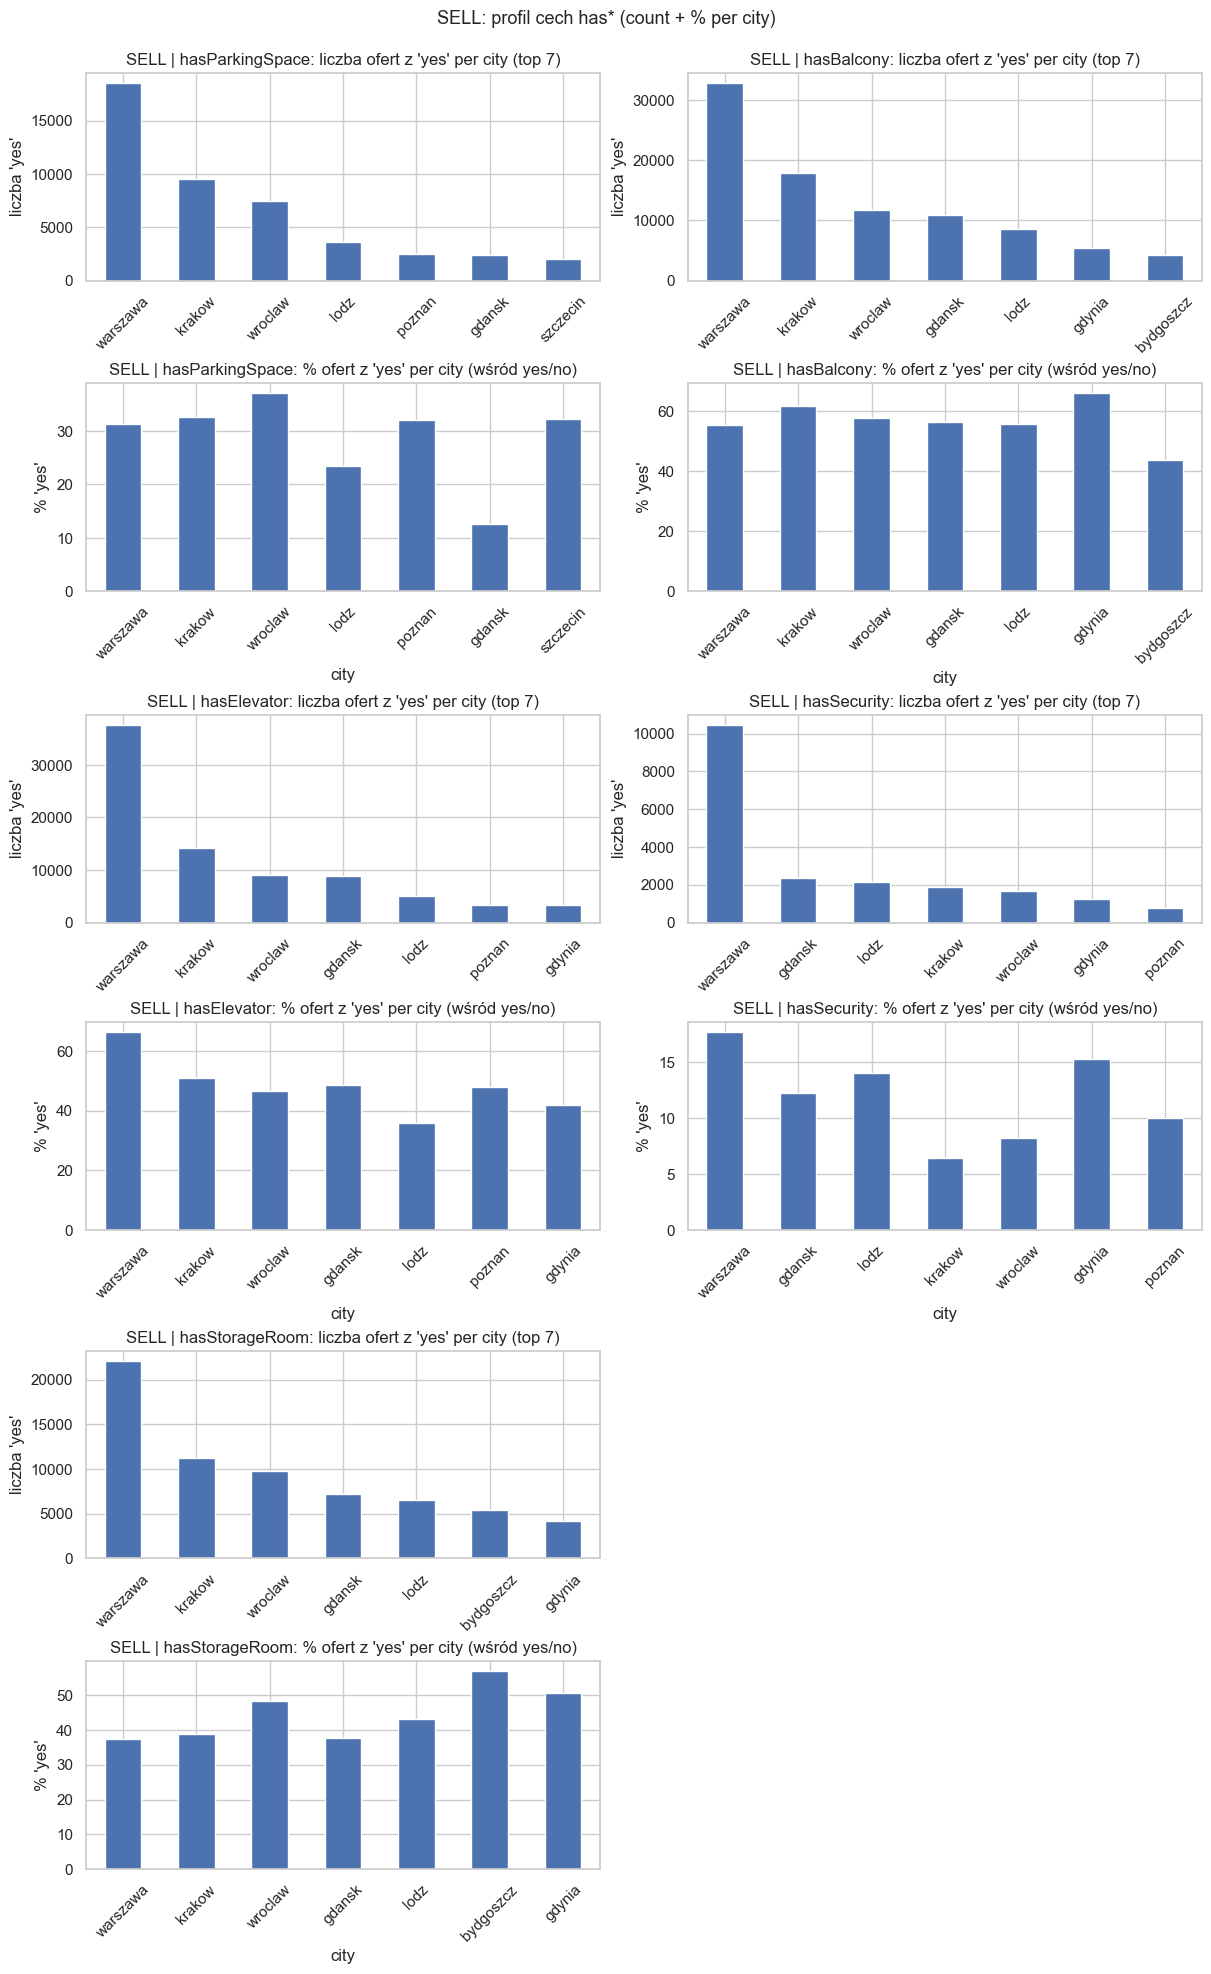

In [ ]:

TOP_N = 7          # None -> pokaż wszystkie miasta
FIG_W = 12

def _sanitize_has_columns(df: pd.DataFrame, has_cols):
    """Zostawia tylko 'yes'/'no', resztę ustawia na NaN."""
    for c in has_cols:
        df[c] = df[c].where(df[c].isin(["yes", "no"]))
    return df

def plot_categorical_profiles(df: pd.DataFrame, label: str, top_n: int | None = 7):
    df = df.copy()
    has_cols = [c for c in df.columns if c.startswith("has")]
    df = _sanitize_has_columns(df, has_cols)

    # 1) Liczba ofert per city
    city_counts = df["city"].value_counts(dropna=False)
    plt.figure(figsize=(FIG_W, 5))
    city_counts.plot(kind="bar")
    plt.title(f"{label}: liczba ofert per city")
    plt.xlabel("city")
    plt.ylabel("liczba ofert")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # 2) % 'yes' dla każdej cechy has* (globalnie, wśród nie-null)
    if has_cols:
        overall_yes_pct = {}
        for c in has_cols:
            non_null = df[c].notna().sum()
            yes_cnt = (df[c] == "yes").sum()
            overall_yes_pct[c] = (yes_cnt / non_null * 100) if non_null > 0 else np.nan

        overall_yes_pct = pd.Series(overall_yes_pct).sort_values(ascending=False)

        plt.figure(figsize=(FIG_W, 5))
        overall_yes_pct.plot(kind="bar")
        plt.title(f"{label}: % 'yes' dla cech has* (globalnie, wśród nie-null)")
        plt.xlabel("cecha")
        plt.ylabel("% 'yes'")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    # 3) Dla każdej cechy has*: (A) liczba 'yes' per city + (B) % 'yes' per city (pod spodem)
    if has_cols:
        n_features = len(has_cols)
        ncols = 2
        nrows = int(np.ceil(n_features / ncols))

        # 2 wiersze na każdą cechę: górny = count, dolny = %
        fig, axes = plt.subplots(
            nrows=nrows * 2,
            ncols=ncols,
            figsize=(FIG_W, max(6, nrows * 2 * 3.2)),
            constrained_layout=True
        )
        axes = np.array(axes)

        for idx, c in enumerate(has_cols):
            r_base = (idx // ncols) * 2
            col = idx % ncols

            # Count yes per city
            yes_by_city = df.groupby("city")[c].apply(lambda s: (s == "yes").sum()).sort_values(ascending=False)

            # Denominator: (yes + no) per city -> non-null count w mieście dla tej cechy
            non_null_by_city = df.groupby("city")[c].apply(lambda s: s.notna().sum())
            pct_yes_by_city = (yes_by_city / non_null_by_city * 100).replace([np.inf, -np.inf], np.nan)

            # TOP N wybieramy wg liczby 'yes' (żeby zachować sens "najwięcej")
            if top_n is not None:
                top_cities = yes_by_city.head(top_n).index
                yes_by_city = yes_by_city.loc[top_cities]
                pct_yes_by_city = pct_yes_by_city.loc[top_cities]

            # --- wykres A: liczba ---
            ax_count = axes[r_base, col]
            yes_by_city.plot(kind="bar", ax=ax_count)
            ax_count.set_title(f"{label} | {c}: liczba ofert z 'yes' per city" + (f" (top {top_n})" if top_n else ""))
            ax_count.set_xlabel("")
            ax_count.set_ylabel("liczba 'yes'")
            ax_count.tick_params(axis="x", rotation=45)

            # --- wykres B: procent ---
            ax_pct = axes[r_base + 1, col]
            pct_yes_by_city.plot(kind="bar", ax=ax_pct)
            ax_pct.set_title(f"{label} | {c}: % ofert z 'yes' per city (wśród yes/no)")
            ax_pct.set_xlabel("city")
            ax_pct.set_ylabel("% 'yes'")
            ax_pct.tick_params(axis="x", rotation=45)

        # Wyłącz niewykorzystane osie (jeśli liczba cech nie wypełnia siatki)
        total_slots = nrows * ncols
        for empty_idx in range(len(has_cols), total_slots):
            r_base = (empty_idx // ncols) * 2
            col = empty_idx % ncols
            axes[r_base, col].axis("off")
            axes[r_base + 1, col].axis("off")

        fig.suptitle(f"{label}: profil cech has* (count + % per city)", y=1.02, fontsize=13)
        plt.show()


# --- URUCHOMIENIA ---
plot_categorical_profiles(df_rent, label="RENT", top_n=TOP_N)
plot_categorical_profiles(df_sell, label="SELL", top_n=TOP_N)

## Wnioski z profilu zmiennych kategorycznych
### 1. Silna nierównowaga ofert między miastami
- Zarówno dla wynajmu, jak i sprzedaży widoczna jest bardzo duża koncentracja ogłoszeń w kilku największych ośrodkach — Warszawa zdecydowanie dominuje, a następnie (z wyraźnym spadkiem) Kraków i Wrocław.
- Taki rozkład oznacza, że wyniki oparte na liczbach bezwzględnych (np. “najwięcej balkonów w Warszawie”) w dużej mierze odzwierciedlają po prostu skalę rynku / liczebność próby, a nie specyfikę zasobów mieszkaniowych.
- Właśnie dlatego dodanie wykresów procentowych jest kluczowe: % `yes` jest bardziej miarodajny w porównaniach między miastami.

### 2. Najczęstsze cechy w RENT vs SELL
- W RENT najbardziej powszechne są: winda (hasElevator) i balkon (hasBalcony) – wartości `yes` stanowią większość obserwacji (ok. 60%+).
- W SELL nadal często występują balkon i winda, ale widać wyraźnie inną strukturę:
	- komórka lokatorska (hasStorageRoom) jest dużo częstsza niż w wynajmie
	- ochrona (hasSecurity) pozostaje cechą relatywnie rzadką 
- Interpretacja rynkowa: sprzedaż mocniej reprezentuje nowe inwestycje / standard deweloperski, gdzie częściej występują: komórki lokatorskie, miejsca postojowe i infrastruktura osiedlowa, w wynajmie częściej pojawiają się mieszkania “użytkowe”, gdzie te dodatki nie zawsze są formalnie przypisane.

### 3. Różnice między rankingiem liczbowym i procentowym
- W rankingach liczbowych TOP miast dla każdej cechy niemal zawsze wygrywa Warszawa — co jest konsekwencją największej liczby ogłoszeń.
- Dopiero wykresy procentowe pokazują realne różnice w strukturze zasobu:
- hasParkingSpace: w wielu miastach udział `yes` jest zbliżony, ale są też wyraźne odstępstwa (np. w części miast udział jest zauważalnie wyższy niż w Warszawie).
- hasBalcony: cecha jest ogólnie bardzo stabilna między największymi miastami (często ok. 55–65% `yes`), co sugeruje, że balkon jest w dużych ośrodkach standardem oferty, a różnice są raczej umiarkowane.
- hasElevator: większe zróżnicowanie procentowe — w niektórych miastach udział `yes` jest zdecydowanie wyższy, co może odzwierciedlać większy udział zabudowy wielopiętrowej / nowszych budynków.
- hasSecurity i hasStorageRoom: cechy rzadziej występujące, ale z większymi wahaniami między miastami

### 4. Różnice miejskie sugerują inny „profil budynków” i segmentację rynku
- Miasta różnią się nie tylko cenami, ale też strukturą cech: w jednych relatywnie częściej występują windy, w innych komórki lokatorskie, a gdzie indziej miejsca parkingowe.
- To wskazuje, że `city` jest zmienną silnie determinującą (nie tylko jako lokalizacja, ale też jako pośrednia informacja o typie zabudowy i standardu), a cechy `has*` mogą działać jako cechy doprecyzowujące segment wewnątrz miasta.

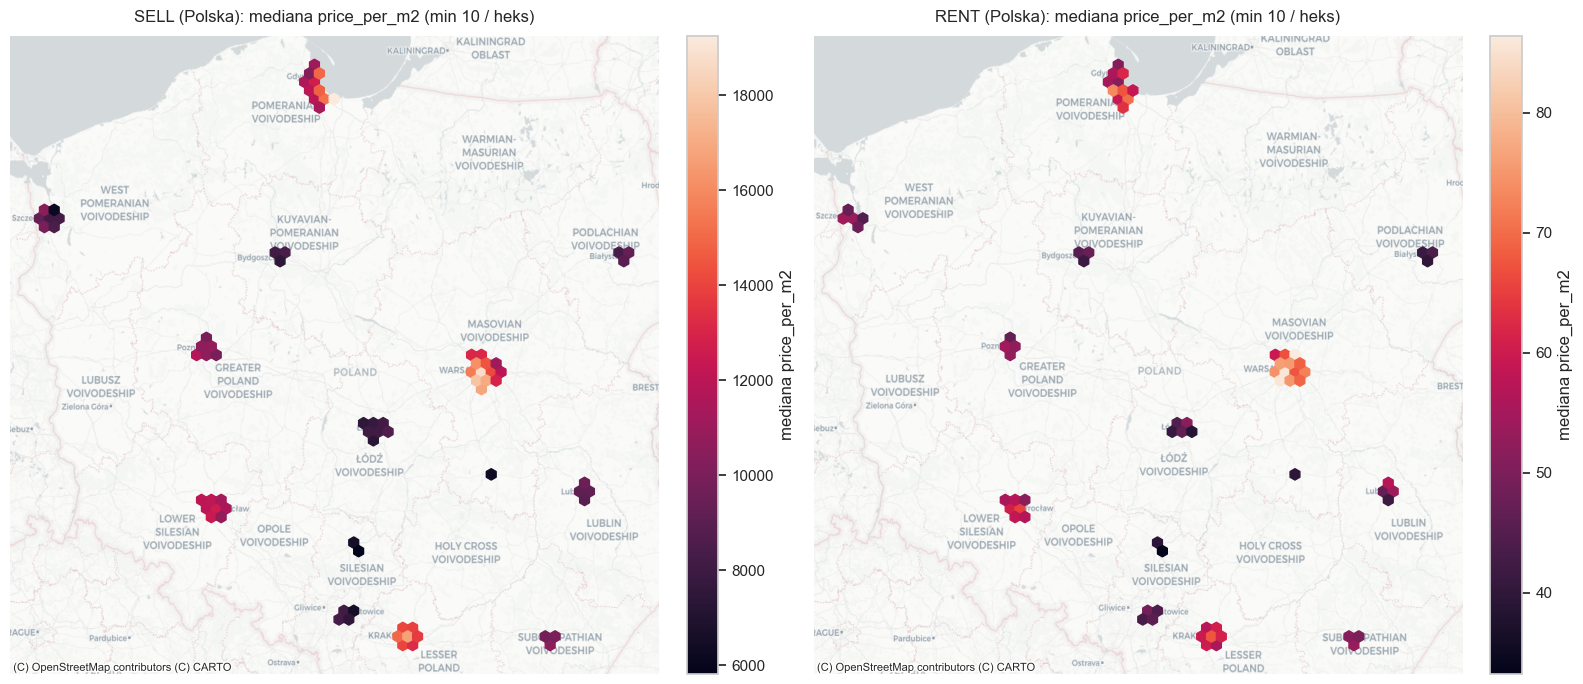

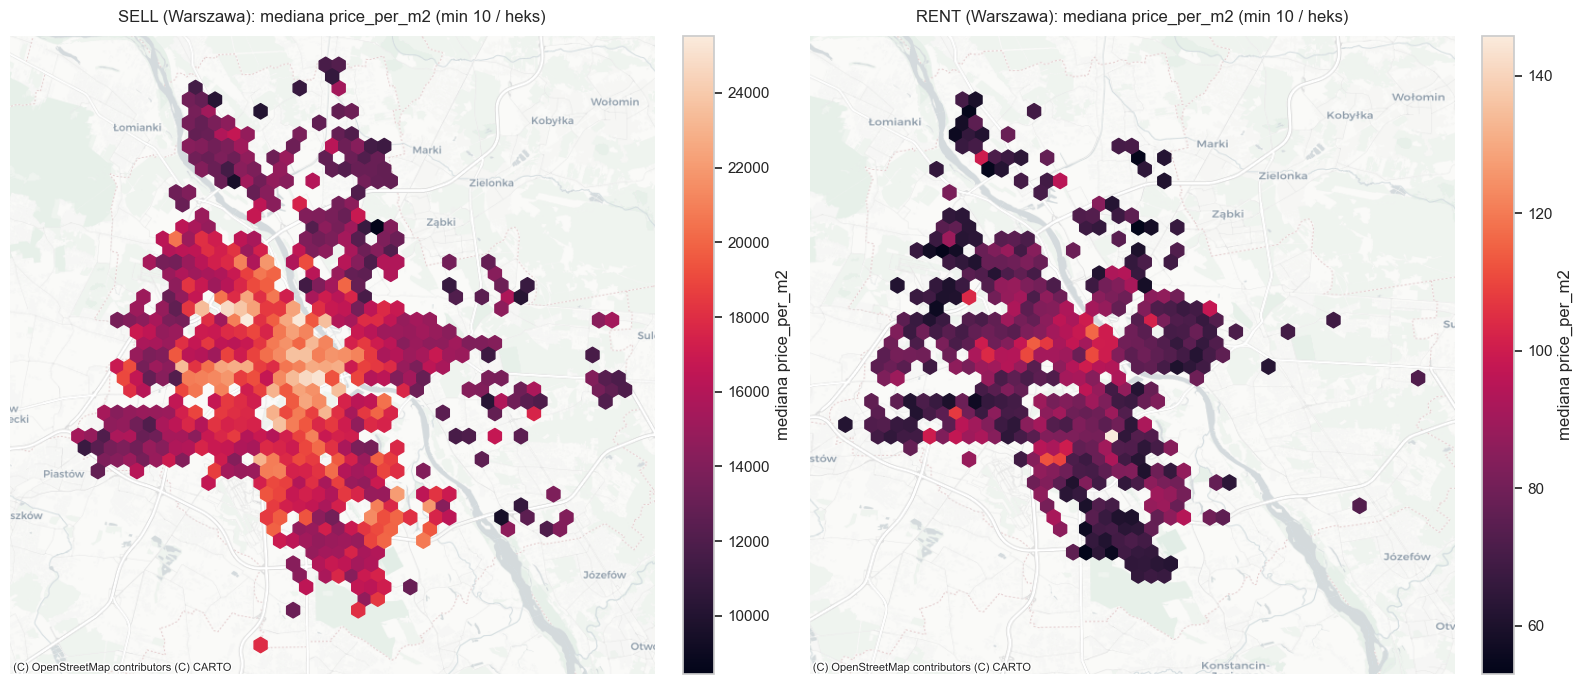

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

# -------------------------
# Helpery
# -------------------------

def ensure_price_per_m2(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "price_per_m2" not in df.columns and {"price", "squareMeters"}.issubset(df.columns):
        df["price_per_m2"] = df["price"] / df["squareMeters"]
    return df

def to_gdf(df: pd.DataFrame) -> gpd.GeoDataFrame:
    geo = df.dropna(subset=["latitude", "longitude"]).copy()
    gdf = gpd.GeoDataFrame(
        geo,
        geometry=gpd.points_from_xy(geo["longitude"], geo["latitude"]),
        crs="EPSG:4326"
    ).to_crs("EPSG:3857")
    return gdf

def filter_city_warsaw(df: pd.DataFrame) -> pd.DataFrame:
    # "na sztywno" Warszawa (odpornie na wielkość liter i spacje)
    city_norm = df["city"].astype(str).str.strip().str.lower()
    return df[city_norm == "warszawa"].copy()

def plot_hex_median_ppm2(ax, gdf, title, gridsize=60, mincnt=10):
    gdf_ppm2 = gdf.dropna(subset=["price_per_m2"]).copy()

    hb = ax.hexbin(
        gdf_ppm2.geometry.x, gdf_ppm2.geometry.y,
        C=gdf_ppm2["price_per_m2"],
        reduce_C_function=np.median,
        gridsize=gridsize,
        mincnt=mincnt
    )

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    xmin, ymin, xmax, ymax = gdf_ppm2.total_bounds
    mx = (xmax - xmin) * 0.05
    my = (ymax - ymin) * 0.05
    ax.set_xlim(xmin - mx, xmax + mx)
    ax.set_ylim(ymin - my, ymax + my)

    ax.set_axis_off()
    ax.set_title(title, pad=10)
    return hb


# -------------------------
# Przygotowanie danych
# -------------------------

df_sell_m = ensure_price_per_m2(df_sell)
df_rent_m = ensure_price_per_m2(df_rent)

# Polska
gdf_sell_pl = to_gdf(df_sell_m)
gdf_rent_pl = to_gdf(df_rent_m)

# Warszawa (na sztywno po city)
df_sell_waw = filter_city_warsaw(df_sell_m)
df_rent_waw = filter_city_warsaw(df_rent_m)

gdf_sell_waw = to_gdf(df_sell_waw)
gdf_rent_waw = to_gdf(df_rent_waw)


# -------------------------
# 1) POLSKA – mediana price_per_m2 (SELL + RENT)
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

hb1 = plot_hex_median_ppm2(
    axes[0], gdf_sell_pl,
    "SELL (Polska): mediana price_per_m2 (min 10 / heks)",
    gridsize=60, mincnt=10
)
hb2 = plot_hex_median_ppm2(
    axes[1], gdf_rent_pl,
    "RENT (Polska): mediana price_per_m2 (min 10 / heks)",
    gridsize=60, mincnt=10
)

fig.colorbar(hb1, ax=axes[0], fraction=0.046, pad=0.04, label="mediana price_per_m2")
fig.colorbar(hb2, ax=axes[1], fraction=0.046, pad=0.04, label="mediana price_per_m2")

plt.tight_layout()
plt.show()


# -------------------------
# 2) WARSZAWA – mediana price_per_m2 (SELL + RENT)
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

hb1 = plot_hex_median_ppm2(
    axes[0], gdf_sell_waw,
    "SELL (Warszawa): mediana price_per_m2 (min 10 / heks)",
    gridsize=45, mincnt=10
)
hb2 = plot_hex_median_ppm2(
    axes[1], gdf_rent_waw,
    "RENT (Warszawa): mediana price_per_m2 (min 10 / heks)",
    gridsize=45, mincnt=10
)

fig.colorbar(hb1, ax=axes[0], fraction=0.046, pad=0.04, label="mediana price_per_m2")
fig.colorbar(hb2, ax=axes[1], fraction=0.046, pad=0.04, label="mediana price_per_m2")

plt.tight_layout()
plt.show()

## Wnioski z map heksowych price_per_m2 

### 1. Obraz dla Polski 
- Na mapach ogólnopolskich widać wyraźną polaryzację cen pomiędzy największymi rynkami a pozostałymi miastami. Dla sprzedaży  najwyższe wartości price_per_m2 koncentrują się w największych aglomeracjach, co jest spójne z intuicją rynkową: silny popyt, wyższe dochody oraz większy udział nowej zabudowy i atrakcyjnych lokalizacji.
- Dla wynajmu  rozkład jest podobny (najdroższe ośrodki nadal dominują), ale skala wartości jest oczywiście inna. W praktyce widać, że zarówno w sprzedaży, jak i w najmie Warszawa dominuje.
- Jednocześnie mapy potwierdzają, że analiza w skali kraju powinna być prowadzona z uwzględnieniem faktu, że porównujemy różne rynki lokalne, a nie jednorodny.

### 2. Obraz dla Warszawy 
- W Warszawie na mapie sprzedaży widać mocny gradient cenowy: najwyższe wartości price_per_m2 układają się w centralnej części miasta i w wybranych kierunkach tworzą spójne „pasma” podwyższonych cen, podczas gdy peryferia (oraz obszary o mniejszej liczbie ofert) częściej wykazują niższe mediany.
- Na mapie wynajmu  wzorzec jest podobny w sensie geograficznym (również wyróżnia się rdzeń i obszary o wyższych stawkach), jednak struktura bywa bardziej rozproszona, co może wynikać z większej heterogeniczności ofert najmu (standard, metraż, segment rynku, krótkoterminowe ogłoszenia itp.).
- Co istotne, oba wykresy  sugerują, że w Warszawie ceny nie rosną równomiernie „od centrum w kółko”, tylko tworzą układ, który może być powiązany z osiami dobrej dostępności komunikacyjnej.

### 3. Droższe lokalizacje wzdłuż M1
- Na mapach Warszawy da się zauważyć układ podwyższonych cen, który luźno przypomina liniowy korytarz. Jedną z naturalnych interpretacji jest wpływ infrastruktury transportowej – w szczególności pierwszej linii metra (M1), która łączy północ–południe i przebiega przez kluczowe obszary miejskie.

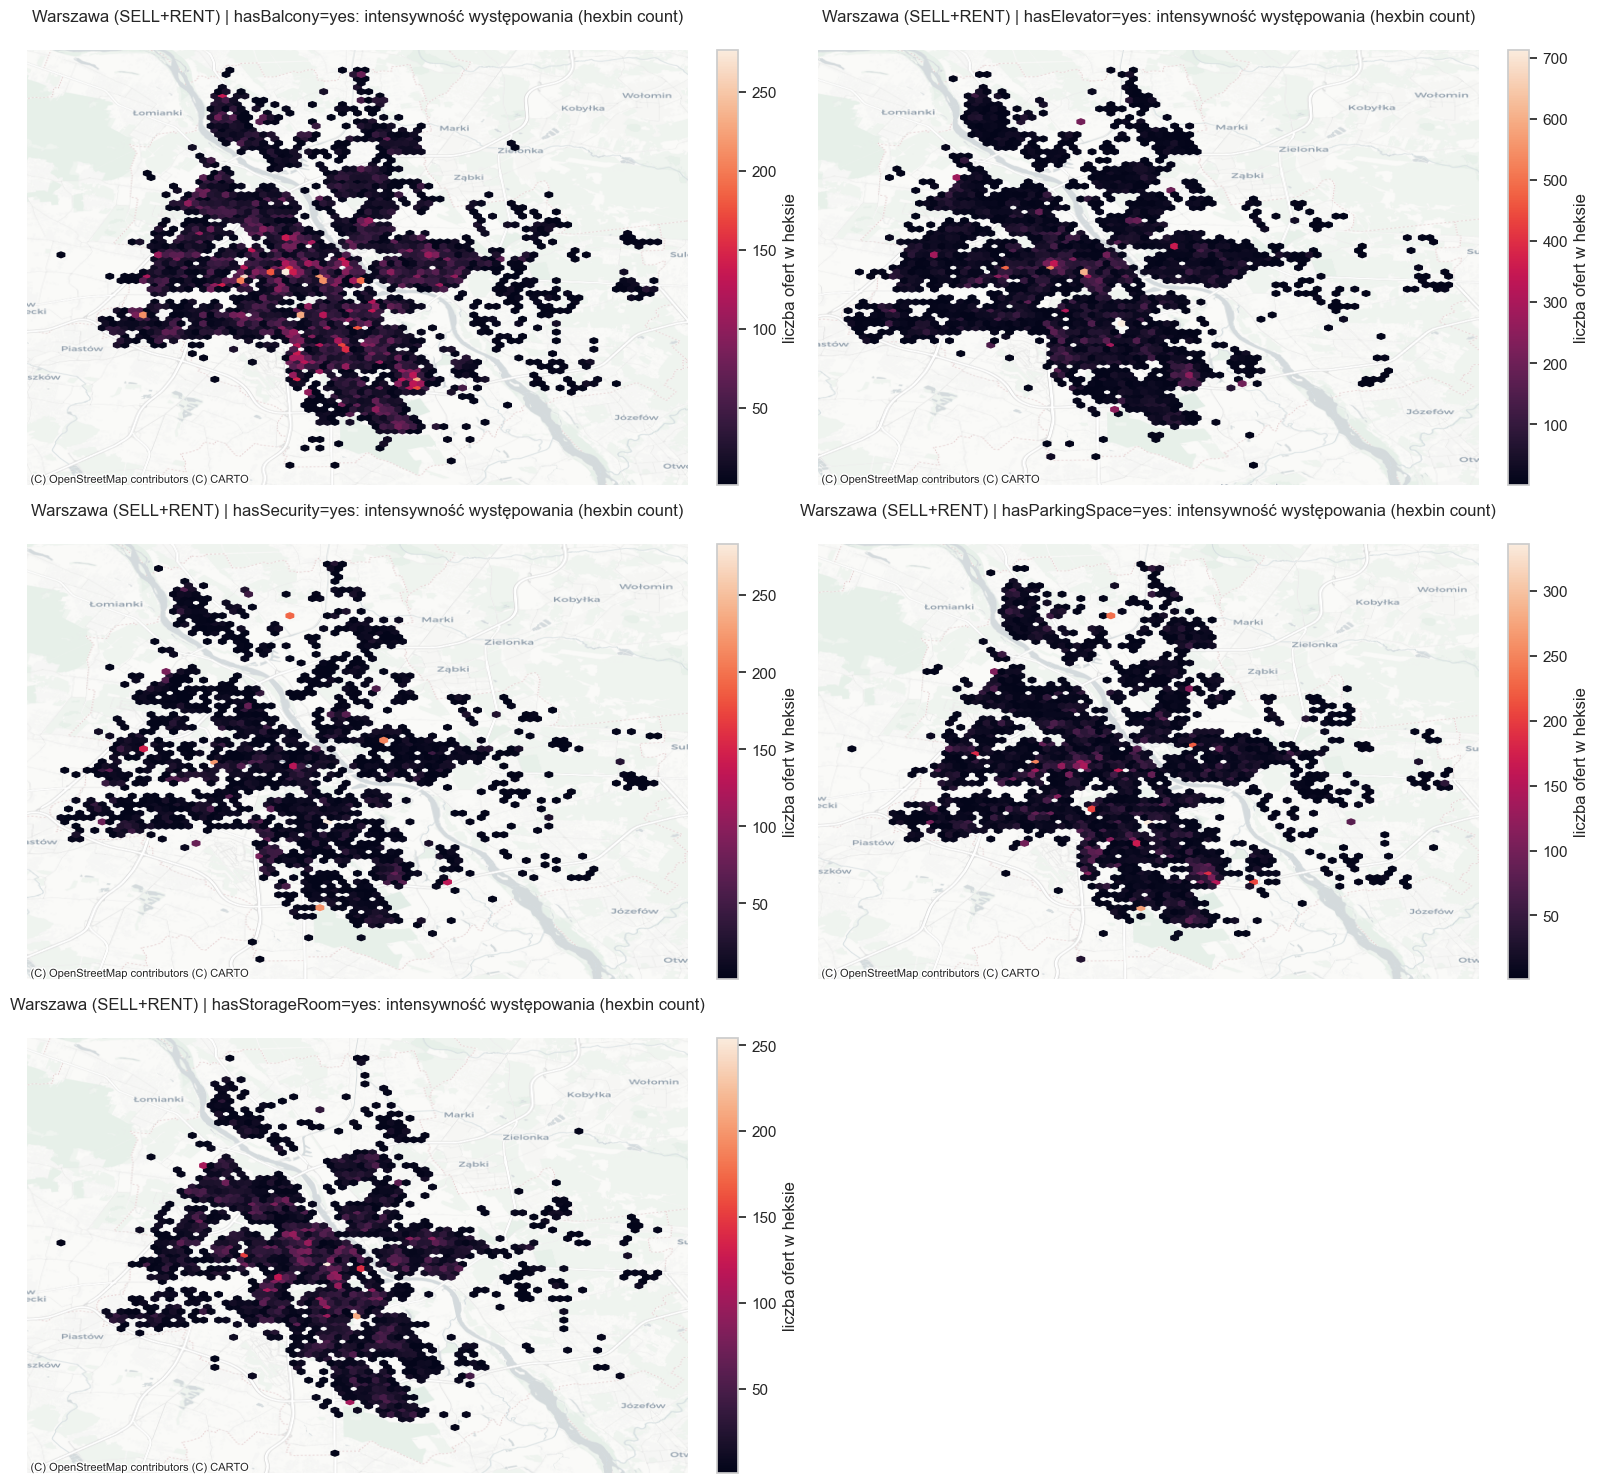

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

# -------------------------
# Konfiguracja
# -------------------------
GRIDSIZE_WAW = 80   # większe = drobniejsze heksy, mniejsze = większe heksy
MINCNT = 1          # pokazuj heksy od 1 oferty

# Jeśli chcesz konkretne cechy, ustaw listę:
FEATURES = ["hasBalcony", "hasElevator", "hasSecurity", "hasParkingSpace", "hasStorageRoom"]
# FEATURES = None  # None => weź wszystkie kolumny zaczynające się od "has"

# -------------------------
# Helpery
# -------------------------
def filter_city_warsaw(df: pd.DataFrame) -> pd.DataFrame:
    city_norm = df["city"].astype(str).str.strip().str.lower()
    return df[city_norm == "warszawa"].copy()

def to_gdf(df: pd.DataFrame) -> gpd.GeoDataFrame:
    geo = df.dropna(subset=["latitude", "longitude"]).copy()
    return gpd.GeoDataFrame(
        geo,
        geometry=gpd.points_from_xy(geo["longitude"], geo["latitude"]),
        crs="EPSG:4326"
    ).to_crs("EPSG:3857")

def plot_hex_density(ax, gdf, title, gridsize=55, mincnt=1):
    hb = ax.hexbin(
        gdf.geometry.x, gdf.geometry.y,
        gridsize=gridsize,
        mincnt=mincnt
    )
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    xmin, ymin, xmax, ymax = gdf.total_bounds
    mx = (xmax - xmin) * 0.05
    my = (ymax - ymin) * 0.05
    ax.set_xlim(xmin - mx, xmax + mx)
    ax.set_ylim(ymin - my, ymax + my)

    ax.set_axis_off()
    ax.set_title(title, pad=10)
    return hb

# -------------------------
# 1) Połącz SELL + RENT i przytnij do Warszawy
# -------------------------
df_all = pd.concat([df_sell, df_rent], ignore_index=True)
df_waw = filter_city_warsaw(df_all)

# has* tylko 'yes'/'no', reszta => NaN (zgodnie z Twoją zasadą)
has_cols = [c for c in df_waw.columns if c.startswith("has")]
for c in has_cols:
    df_waw[c] = df_waw[c].where(df_waw[c].isin(["yes", "no"]))

# wybór cech do rysowania
if FEATURES is None:
    features = has_cols
else:
    features = [c for c in FEATURES if c in df_waw.columns]

gdf_waw = to_gdf(df_waw)

# -------------------------
# 2) Mapy intensywności: gdzie są oferty z cechą = 'yes'
# -------------------------
if len(features) == 0:
    raise ValueError("Brak kolumn has* do narysowania (features jest puste).")

n = len(features)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(16, max(6, nrows * 5)))
axes = np.array(axes).reshape(-1)

for i, feat in enumerate(features):
    ax = axes[i]

    subset = gdf_waw[gdf_waw[feat] == "yes"].copy()
    if subset.empty:
        ax.axis("off")
        ax.set_title(f"Warszawa | {feat}=yes: brak punktów")
        continue

    hb = plot_hex_density(
        ax,
        subset,
        title=f"Warszawa (SELL+RENT) | {feat}=yes: intensywność występowania (hexbin count)",
        gridsize=GRIDSIZE_WAW,
        mincnt=MINCNT
    )

    fig.colorbar(hb, ax=ax, fraction=0.046, pad=0.04, label="liczba ofert w heksie")

# wyłącz niewykorzystane osie
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Wnioski z map intensywności występowania cech has* w Warszawie

### 1. Co dokładnie pokazują mapy
- Mapy przedstawiają zagęszczenie ofert (hexbin count) spełniających warunek `hasX = yes`, czyli gdzie dana cecha (np. balkon, winda, ochrona) występuje w ogłoszeniach.

### 2. Balkon (hasBalcony)
- Balkon jest cechą szeroko rozpowszechnioną – mapa jest stosunkowo „pełna”, co sugeruje, że w wielu częściach Warszawy oferty z balkonem pojawiają się regularnie.
- Największe natężenia występują w obszarach o wysokiej aktywności rynku (duża liczba ogłoszeń), co jest spójne z tym, że balkon jest standardem oferty w wielu segmentach

### 3. Winda (hasElevator)
- hasElevator generuje wyraźnie silniejsze ogniska koncentracji niż balkon, co wskazuje na duży wolumen ofert w zabudowie, gdzie winda jest typowym wyposażeniem.
- Przestrzennie rozkład jest zgodny z intuicją urbanistyczną: winda częściej pojawia się tam, gdzie dominuje zabudowa wielopiętrowa lub nowsze inwestycje mieszkaniowe. Jednocześnie brak widocznych „punktowych” koncentracji sugeruje, że to cecha strukturalna dla typów budynków, a nie atrybut związany z pojedynczymi mikro-lokalizacjami.

### 4. Ochrona (hasSecurity)
- hasSecurity jest cechą zdecydowanie rzadszą – mapa zawiera mniej silnych koncentracji, a wiele heksów ma niską intensywność.
- W praktyce oznacza to, że ochrona w ogłoszeniach jest bardziej charakterystyczna dla wybranych inwestycji/kompleksów (np. osiedla zamknięte, segment premium), a nie dla całego rynku.

### 5. Miejsce parkingowe (hasParkingSpace)
- Cecha występuje częściej niż ochrona, ale jej natężenia są bardziej selektywne niż w przypadku balkonu.
- Przestrzennie może to odzwierciedlać większy udział inwestycji, w których parking jest przypisany do lokalu (garaże podziemne, miejsca postojowe), co bywa częstsze w nowszej zabudowie i określonych typach osiedli.

### 6. Komórka lokatorska (hasStorageRoom)
- hasStorageRoom wykazuje stosunkowo szeroki zasięg, ale intensywności są wyraźnie niższe niż przy windzie.
- To sugeruje, że komórka lokatorska pojawia się jako cecha istotna, lecz mniej „domyślna” niż balkon czy winda – może być mocniej związana z konkretnymi typami budynków i standardem inwestycji.

/Users/pawel/Dev/PW/III sem/PRiAD/PRIAD-projekt/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4786: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


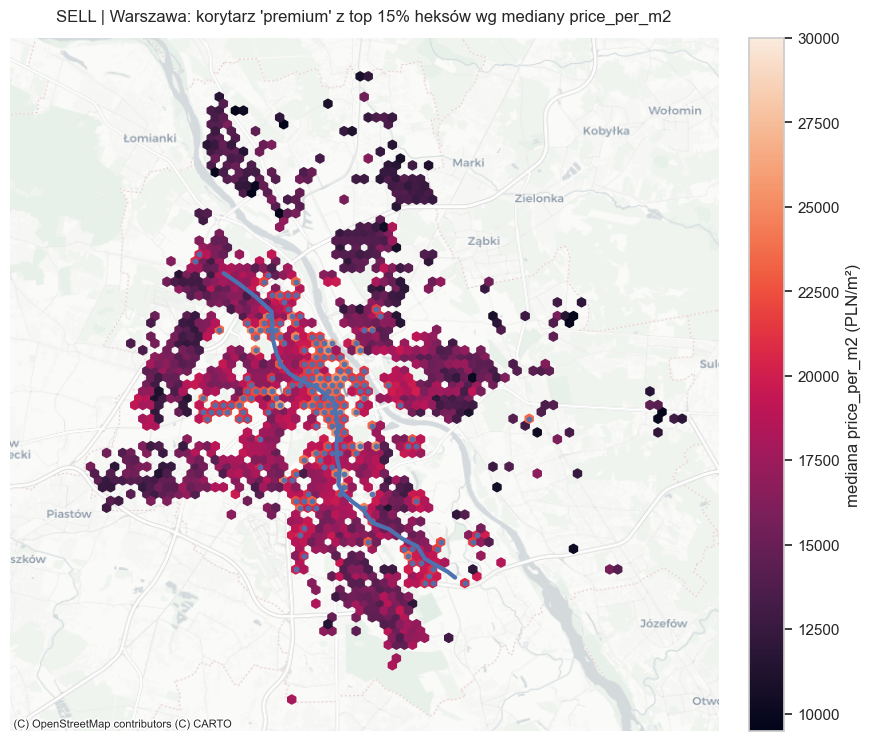

/Users/pawel/Dev/PW/III sem/PRiAD/PRIAD-projekt/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4786: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


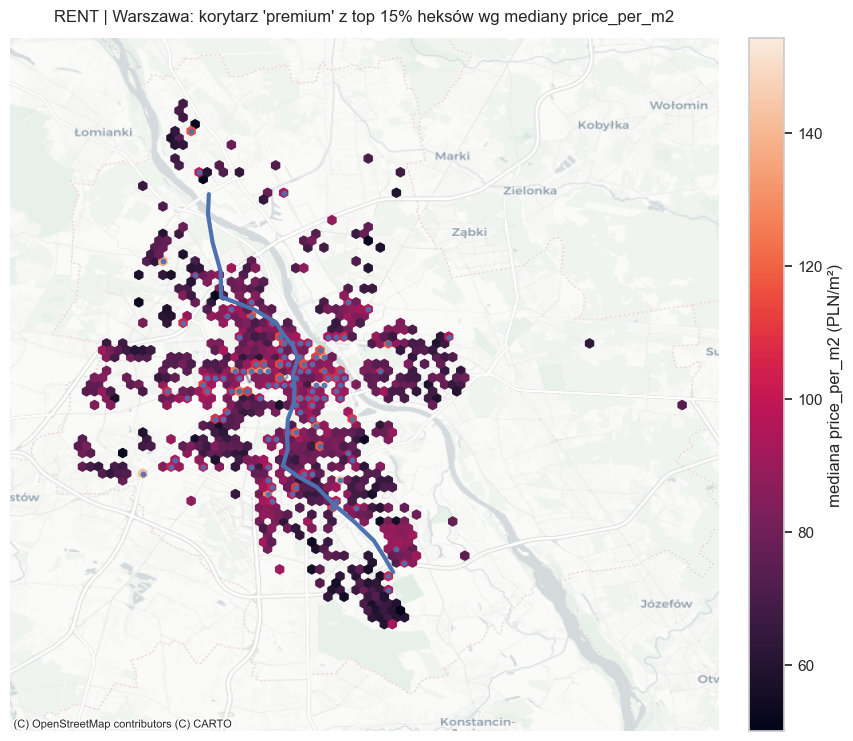

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

# -------------------------
# Konfiguracja
# -------------------------
GRIDSIZE_WAW = 80     # siatka heksów
MINCNT = 10           # min liczba ofert w heksie, żeby liczyć medianę
TOP_Q = 0.85          # bierzemy top 10% heksów wg mediany price_per_m2
N_SEGMENTS = 35       # ile punktów kontrolnych ma mieć "ścieżka"
SMOOTH_WINDOW = 5     # wygładzanie punktów ścieżki (1 = brak)

# -------------------------
# Helpery
# -------------------------
def ensure_price_per_m2(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "price_per_m2" not in df.columns and {"price", "squareMeters"}.issubset(df.columns):
        df["price_per_m2"] = df["price"] / df["squareMeters"]
    return df

def filter_warsaw(df: pd.DataFrame) -> pd.DataFrame:
    city_norm = df["city"].astype(str).str.strip().str.lower()
    return df[city_norm == "warszawa"].copy()

def to_gdf(df: pd.DataFrame) -> gpd.GeoDataFrame:
    geo = df.dropna(subset=["latitude", "longitude"]).copy()
    gdf = gpd.GeoDataFrame(
        geo,
        geometry=gpd.points_from_xy(geo["longitude"], geo["latitude"]),
        crs="EPSG:4326"
    ).to_crs("EPSG:3857")
    return gdf

def pca_first_component(points_xy: np.ndarray):
    """
    points_xy: (n,2) w metrach (EPSG:3857).
    Zwraca: mean, unit_vector_pc1, unit_vector_pc2
    """
    mean = points_xy.mean(axis=0)
    X = points_xy - mean
    cov = np.cov(X.T)
    vals, vecs = np.linalg.eigh(cov)        # eigenvalues ascending
    pc1 = vecs[:, np.argmax(vals)]
    pc1 = pc1 / np.linalg.norm(pc1)
    pc2 = np.array([-pc1[1], pc1[0]])
    return mean, pc1, pc2

def build_path_from_top_hex_centers(centers_xy: np.ndarray, n_segments: int = 35, smooth_window: int = 3):
    """
    Buduje "ścieżkę" jako uporządkowane punkty kontrolne wzdłuż osi PC1:
    - rzut na PC1
    - podział na segmenty
    - średnie punktów w segmentach
    - opcjonalne wygładzenie
    """
    mean, pc1, pc2 = pca_first_component(centers_xy)
    X = centers_xy - mean
    t = X @ pc1  # współrzędna wzdłuż głównej osi

    # segmentacja po t
    t_min, t_max = np.min(t), np.max(t)
    edges = np.linspace(t_min, t_max, n_segments + 1)

    path_pts = []
    for a, b in zip(edges[:-1], edges[1:]):
        mask = (t >= a) & (t < b)
        if mask.sum() == 0:
            continue
        # średni punkt w segmencie (w 2D)
        path_pts.append(centers_xy[mask].mean(axis=0))

    path_pts = np.array(path_pts)
    if len(path_pts) < 3:
        return path_pts

    # wygładzanie kroczące
    if smooth_window and smooth_window > 1:
        k = smooth_window
        pad = k // 2
        padded = np.pad(path_pts, ((pad, pad), (0, 0)), mode="edge")
        smoothed = []
        for i in range(len(path_pts)):
            smoothed.append(padded[i:i+k].mean(axis=0))
        path_pts = np.array(smoothed)

    return path_pts

def plot_premium_corridor(df: pd.DataFrame, title_prefix: str,
                          gridsize: int = 55, mincnt: int = 10,
                          top_q: float = 0.90, n_segments: int = 35, smooth_window: int = 3):
    """
    1) Tworzy heksy z medianą price_per_m2
    2) Bierze top (1-top_q) heksów jako "premium"
    3) Dopasowuje heurystyczną 'oś premium' (PCA + segmentacja)
    4) Rysuje na mapie: wszystkie heksy (kolor = mediana), wyróżnia top-heksy, i ścieżkę
    """
    df = ensure_price_per_m2(df)
    df = filter_warsaw(df)
    gdf = to_gdf(df).dropna(subset=["price_per_m2"]).copy()

    fig, ax = plt.subplots(figsize=(10, 9))

    # hexbin mediany (to tworzy "rastr" mediany ceny)
    hb = ax.hexbin(
        gdf.geometry.x, gdf.geometry.y,
        C=gdf["price_per_m2"],
        reduce_C_function=np.median,
        gridsize=gridsize,
        mincnt=mincnt
    )

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # widok na obszar danych
    xmin, ymin, xmax, ymax = gdf.total_bounds
    mx = (xmax - xmin) * 0.05
    my = (ymax - ymin) * 0.05
    ax.set_xlim(xmin - mx, xmax + mx)
    ax.set_ylim(ymin - my, ymax + my)
    ax.set_axis_off()

    # wyciągamy centra heksów i ich wartości (mediany)
    centers = hb.get_offsets()          # (n_hex, 2)
    values = hb.get_array()             # (n_hex,)

    # top-heksy (premium) wg kwantyla
    thr = np.nanquantile(values, top_q)
    top_mask = values >= thr
    top_centers = centers[top_mask]

    # budowa ścieżki po top-heksach
    path_pts = build_path_from_top_hex_centers(
        top_centers,
        n_segments=n_segments,
        smooth_window=smooth_window
    )

    # rysowanie top-heksów jako punkty (overlay)
    ax.scatter(top_centers[:, 0], top_centers[:, 1], s=10, alpha=0.9)

    # rysowanie ścieżki
    if len(path_pts) >= 2:
        ax.plot(path_pts[:, 0], path_pts[:, 1], linewidth=3)

    ax.set_title(f"{title_prefix} | Warszawa: korytarz 'premium' z top {int((1-top_q)*100)}% heksów wg mediany price_per_m2", pad=12)
    plt.colorbar(hb, ax=ax, fraction=0.046, pad=0.04, label="mediana price_per_m2 (PLN/m²)")

    plt.show()

# -------------------------
# Uruchomienie: SELL i RENT osobno
# -------------------------
plot_premium_corridor(df_sell, "SELL", gridsize=GRIDSIZE_WAW, mincnt=MINCNT, top_q=TOP_Q, n_segments=N_SEGMENTS, smooth_window=SMOOTH_WINDOW)
plot_premium_corridor(df_rent, "RENT", gridsize=GRIDSIZE_WAW, mincnt=MINCNT, top_q=TOP_Q, n_segments=N_SEGMENTS, smooth_window=SMOOTH_WINDOW)

## Wnioski z próby odtworzenia przebiegu linii metra na podstawie cen w Warszawie

### 1. Cel i założenie eksperymentu
- W tej części analizy podjęto próbę przewidzenia przybliżonego przebiegu pierwszej linii metra (M1) w Warszawie, korzystając wyłącznie z informacji zawartych w danych ofertowych.
- Założeniem było, że dostęp do metra istotnie wpływa na atrakcyjność lokalizacji, a więc może przekładać się na wyższe średnie/medianowe ceny za m² w obszarach położonych wzdłuż osi transportowej.

### 2. Metoda (intuicja)
- Na siatce heksów obliczono medianę price_per_m2 i wybrano obszary o najwyższych wartościach (top 15% heksów).
- Następnie na podstawie geometrii tych obszarów wyznaczono ciągłą linię, która ma reprezentować dominującą oś przestrzenną wysokich cen.
- Kluczowe jest to, że procedura nie korzystała z żadnych danych o transporcie (brak lokalizacji stacji, przebiegu torów, przystanków), więc wynik jest wyłącznie wnioskowaniem pośrednim na podstawie rozkładu cen.

### 3. Wynik: zgodność z rzeczywistym przebiegiem M1
- Otrzymana linia jest mocno zbliżona do rzeczywistego przebiegu M1, zwłaszcza w wariancie dla sprzedaży (SELL). Widoczna jest dominująca orientacja północ–południe i przebieg przez obszary o najwyższych medianach cen.
- Dla wynajmu (RENT) zgodność również jest widoczna, ale rezultat jest mniej jednoznaczny i bardziej podatny na lokalne odchylenia

### 4. Odchylenie na południu (kierunek Wilanowa)
- W obu wariantach zauważalne jest, że dolny fragment wyznaczonej trasy odchyla się bardziej w stronę Wilanowa niż rzeczywista M1.
- To prawdopodobnie efekt tego, że Wilanów jest obszarem o relatywnie wysokich cenach, a metoda oparta na cenie/m² traktuje takie dzielnice jako “silny sygnał”, mimo że nie wynika on bezpośrednio z przebiegu M1.
- Ten element pokazuje ograniczenie podejścia: rozkład cen odzwierciedla jednocześnie wiele czynników (centrum, standard zabudowy, prestiż lokalizacji, infrastruktura), a nie wyłącznie dostępność metra.

# 5. Statystyki liczbowe

In [25]:
import numpy as np
import pandas as pd

# Ustaw percentyle do describe()
PCTS = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]

def ensure_price_per_m2(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "price_per_m2" not in df.columns and {"price", "squareMeters"}.issubset(df.columns):
        df["price_per_m2"] = df["price"] / df["squareMeters"]
    return df

def stats_table(df: pd.DataFrame, label: str) -> pd.DataFrame:
    df = ensure_price_per_m2(df)

    wanted = ["price", "squareMeters", "rooms", "centreDistance", "buildYear", "price_per_m2"]
    cols = [c for c in wanted if c in df.columns]

    # describe() dla kluczowych zmiennych + percentyle
    desc = df[cols].describe(percentiles=PCTS).T  # transpozycja: wiersze=zmienne
    desc.insert(0, "dataset", label)

    # czytelność: zaokrąglenie (cen i dystansów), buildYear bez zmian (jeśli float, zostanie zaokrąglone)
    # możesz zmienić round(2) na round(0) jeśli wolisz
    return desc.round(2)

stats_sell = stats_table(df_sell, "SELL")
stats_rent = stats_table(df_rent, "RENT")

display(stats_sell)
display(stats_rent)

dataset     count       mean        std        min         1%         5%        10%        25%        50%        75%         90%         95%         99%         max
price             SELL  195568.0  784183.30  409709.23  150000.00  229000.00  309000.00  370000.00  520000.00  699000.00  930000.00  1299000.00  1594755.00  2320858.00  3250000.00
squareMeters      SELL  195568.0      58.70      21.41      25.00      26.50      31.76      36.00      44.00      54.60      68.55       87.00      101.00      130.65      150.00
rooms             SELL  195568.0       2.68       0.92       1.00       1.00       1.00       2.00       2.00       3.00       3.00        4.00        4.00        5.00        6.00
centreDistance    SELL  195568.0       4.35       2.84       0.01       0.30       0.65       1.00       2.01       3.98       6.15        8.16        9.72       12.35       16.94
buildYear         SELL  163352.0    1985.98      33.81    1850.00    1899.00    1915.00    1934.00    1967.00    1994.00    2016.00     2022.00     2023.00     2024.00     2024.00
price_per_m2      SELL  195568.0   13547.73    5024.20    3000.00    5270.27    6483.17    7357.89    9681.44   12978.72   16769.84    20387.93    22827.33    27156.47    32096.77

dataset    count     mean      std      min       1%       5%      10%      25%      50%      75%      90%      95%       99%       max
price             RENT  70847.0  3852.80  2381.54   346.00  1300.00  1700.00  1999.00  2500.00  3100.00  4490.00  6500.00  8500.00  14000.00  23000.00
squareMeters      RENT  70847.0    55.25    22.69    25.00    25.54    30.00    33.00    40.00    50.00    64.00    87.00   104.00    135.00    150.00
rooms             RENT  70847.0     2.38     0.87     1.00     1.00     1.00     2.00     2.00     2.00     3.00     3.00     4.00      5.00      6.00
centreDistance    RENT  70847.0     3.86     2.61     0.02     0.27     0.61     0.90     1.77     3.38     5.42     7.41     8.98     11.54     16.62
buildYear         RENT  51165.0  1998.11    30.29  1850.00  1900.00  1930.00  1951.00  1984.00  2010.00  2020.00  2022.00  2023.00   2023.00   2024.00
price_per_m2      RENT  70847.0    69.20    23.35    11.30    29.55    37.74    43.13    53.00    65.96    81.58    99.16   112.24    145.00    189.47